<a href="https://colab.research.google.com/github/Lee-jun-young98/Penguin-s_weight_prediction_dacon/blob/main/%ED%8E%AD%EA%B7%84%EB%AA%B8%EB%AC%B4%EA%B2%8C%EC%98%88%EC%B8%A12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

코드 따라 치기
https://dacon.io/competitions/official/235862/codeshare/4068?page=1&dtype=recent

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

import os 
os.chdir("/content/gdrive/MyDrive/Dacon/penguin's_weight_prediction/")
os.getcwd()

Mounted at /content/gdrive/


"/content/gdrive/MyDrive/Dacon/penguin's_weight_prediction"

In [ ]:
! pip install catboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import set_option
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, AdaBoostClassifier
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import preprocessing
import seaborn as sns

     |████████████████████████████████| 76.3 MB 1.1 MB/s 


In [ ]:
# id column은 필요없으니 제거
train_dataset = pd.read_csv('train.csv').drop(['id'],axis=1)
test_dataset = pd.read_csv('test.csv').drop(['id'],axis=1)

In [ ]:
for col in train_dataset.columns:
    n_nan = train_dataset[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

        Sex         에서 결측치 개수 : 3개
 Delta 15 N (o/oo)  에서 결측치 개수 : 3개
 Delta 13 C (o/oo)  에서 결측치 개수 : 3개


In [ ]:
train_dataset.head()

,Species,Island,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g)
0,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,50.0,15.3,220,MALE,8.30515,-25.19017,5550
1,Chinstrap penguin (Pygoscelis antarctica),Dream,No,49.5,19.0,200,MALE,9.63074,-24.34684,3800
2,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,45.1,14.4,210,FEMALE,8.51951,-27.01854,4400
3,Gentoo penguin (Pygoscelis papua),Biscoe,Yes,44.5,14.7,214,FEMALE,8.20106,-26.16524,4850
4,Gentoo penguin (Pygoscelis papua),Biscoe,No,49.6,16.0,225,MALE,8.38324,-26.84272,5700


In [ ]:
for col in test_dataset.columns:
    n_nan = test_dataset[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

        Sex         에서 결측치 개수 : 6개
 Delta 15 N (o/oo)  에서 결측치 개수 : 9개
 Delta 13 C (o/oo)  에서 결측치 개수 : 8개


In [ ]:
train_dataset['Sex']=np.where(train_dataset['Sex'].values=='MALE',1,np.where(train_dataset['Sex'].values=='FEMALE',0,np.nan))
test_dataset['Sex']=np.where(test_dataset['Sex'].values=='MALE',1,np.where(test_dataset['Sex'].values=='FEMALE',0,np.nan))
train_dataset['Clutch Completion']=np.where(train_dataset['Clutch Completion'].values=='Yes',1,0)
test_dataset['Clutch Completion']=np.where(test_dataset['Clutch Completion'].values=='Yes',1,0)
train = pd.concat([train_dataset,pd.get_dummies(train_dataset[['Island','Species']])],axis=1)
test = pd.concat([test_dataset,pd.get_dummies(test_dataset[['Island','Species']])],axis=1)
train = train.drop(['Island','Species'],axis=1)
test = test.drop(['Island','Species'],axis=1)

In [ ]:
train.head()


,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
0,1,50.0,15.3,220,1.0,8.30515,-25.19017,5550,1,0,0,0,0,1
1,0,49.5,19.0,200,1.0,9.63074,-24.34684,3800,0,1,0,0,1,0
2,1,45.1,14.4,210,0.0,8.51951,-27.01854,4400,1,0,0,0,0,1
3,1,44.5,14.7,214,0.0,8.20106,-26.16524,4850,1,0,0,0,0,1
4,0,49.6,16.0,225,1.0,8.38324,-26.84272,5700,1,0,0,0,0,1


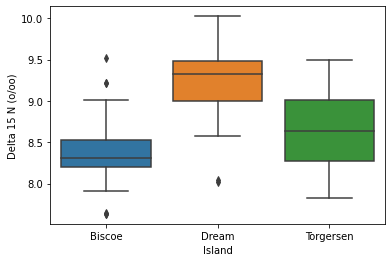

In [ ]:
sns.boxplot(x='Island', y='Delta 15 N (o/oo)', data=train_dataset[['Island','Delta 15 N (o/oo)']])
plt.show()

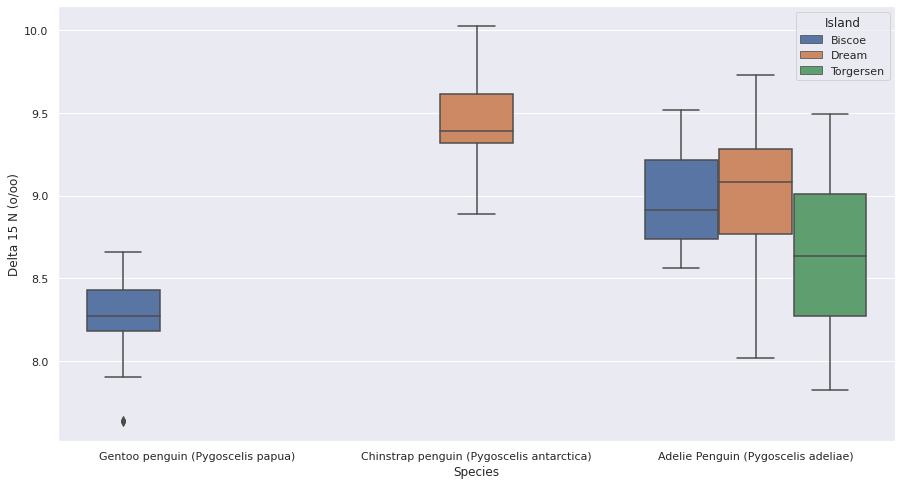

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 15 N (o/oo)',hue = 'Island', data=train_dataset[['Island','Species','Delta 15 N (o/oo)']])
plt.show()


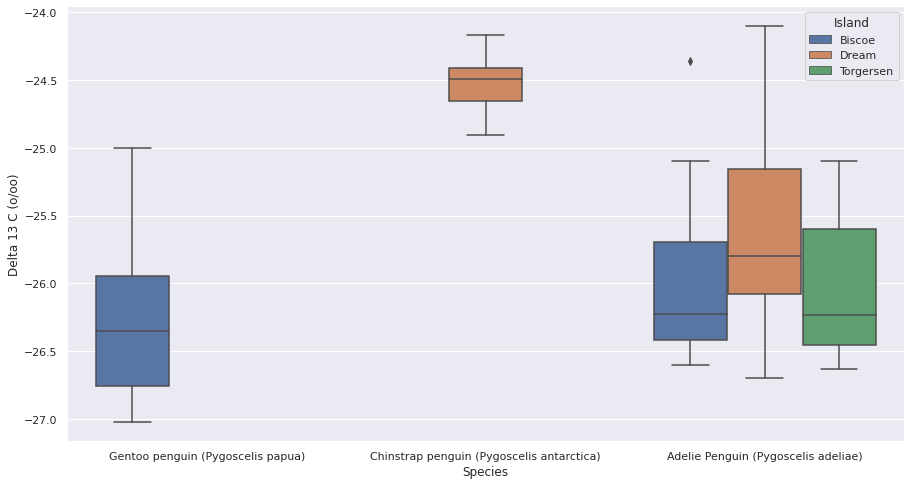

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.boxplot(x='Species', y='Delta 13 C (o/oo)',hue = 'Island', data=train_dataset[['Island','Species','Delta 13 C (o/oo)']])
plt.show()

# 숫자형 데이터들간의 피어슨 상관계수
피어슨 상관계수 설명 : 피어슨 상관 계수(Pearson Correlation Coefficient ,PCC)란 두 변수 X 와 Y 간의 선형 상관 관계를 계량화한 수치다 . 피어슨 상관 계수는 코시-슈바르츠 부등식에 의해 +1과 -1 사이의 값을 가지며, +1은 완벽한 양의 선형 상관 관계, 0은 선형 상관 관계 없음, -1은 완벽한 음의 선형 상관 관계를 의미한다. https://ko.wikipedia.org/wiki/%ED%94%BC%EC%96%B4%EC%8A%A8_%EC%83%81%EA%B4%80_%EA%B3%84%EC%88%98
출처 : 위키백과

In [ ]:
set_option('precision',2)
train.corr(method='pearson')

,Clutch Completion,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Body Mass (g),Island_Biscoe,Island_Dream,Island_Torgersen,Species_Adelie Penguin (Pygoscelis adeliae),Species_Chinstrap penguin (Pygoscelis antarctica),Species_Gentoo penguin (Pygoscelis papua)
Clutch Completion,1.00,-0.12,-0.21,0.11,-1.13e-01,-0.28,-0.29,0.09,2.29e-01,-3.15e-01,0.12,0.08,-0.30,0.18
Culmen Length (mm),-0.12,1.00,-0.25,0.67,3.24e-01,-0.04,0.11,0.57,2.97e-01,-4.72e-02,-0.39,-0.82,0.38,0.48
Culmen Depth (mm),-0.21,-0.25,1.00,-0.60,3.69e-01,0.65,0.48,-0.49,-7.25e-01,5.60e-01,0.28,0.52,0.38,-0.83
Flipper Length (mm),0.11,0.67,-0.60,1.00,2.51e-01,-0.53,-0.45,0.86,7.40e-01,-5.66e-01,-0.30,-0.69,-0.25,0.88
Sex,-0.11,0.32,0.37,0.25,1.00e+00,0.14,-0.10,0.42,-9.09e-03,-7.30e-03,0.03,0.05,-0.07,0.01
Delta 15 N (o/oo),-0.28,-0.04,0.65,-0.53,1.36e-01,1.00,0.64,-0.55,-6.44e-01,7.03e-01,-0.07,0.17,0.65,-0.71
Delta 13 C (o/oo),-0.29,0.11,0.48,-0.45,-9.94e-02,0.64,1.00,-0.47,-5.89e-01,6.74e-01,-0.11,-0.09,0.76,-0.56
Body Mass (g),0.09,0.57,-0.49,0.86,4.20e-01,-0.55,-0.47,1.00,7.08e-01,-5.74e-01,-0.24,-0.51,-0.39,0.82
Island_Biscoe,0.23,0.30,-0.72,0.74,-9.09e-03,-0.64,-0.59,0.71,1.00e+00,-7.93e-01,-0.36,-0.42,-0.53,0.85
Island_Dream,-0.32,-0.05,0.56,-0.57,-7.30e-03,0.70,0.67,-0.57,-7.93e-01,1.00e+00,-0.28,0.12,0.67,-0.68


Sex 결측치 채우기

In [ ]:
sex_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen'
       ]


In [ ]:
models = []
models.append(('LR',LogisticRegression(solver='liblinear',multi_class = 'ovr')))
models.append(('LDA',LinearDiscriminantAnalysis()))
models.append(('KNN',KNeighborsClassifier()))
models.append(('CART',DecisionTreeClassifier()))
models.append(('NB',GaussianNB()))
models.append(('SVM',SVC(gamma='auto')))
models.append(('RFC',RandomForestClassifier()))
models.append(('XGBC',XGBClassifier(iterations=10000,verbose=False)))
models.append(('LGBMC',LGBMClassifier()))
models.append(('AdaC',AdaBoostClassifier()))
models.append(('Cat',CatBoostClassifier(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[sex_features].iloc[train['Sex'].dropna().index]
                               ,train['Sex'].iloc[train['Sex'].dropna().index]
                               ,cv= kfold,scoring='accuracy')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : 0.721212 (0.083320) 
LDA : 0.874242 (0.091926) 
KNN : 0.775000 (0.092291) 
CART : 0.765152 (0.109940) 
NB : 0.702273 (0.147447) 
SVM : 0.737879 (0.138543) 
RFC : 0.809848 (0.111672) 
XGBC : 0.818939 (0.108227) 
LGBMC : 0.818939 (0.082186) 
AdaC : 0.891667 (0.068270) 
Cat : 0.810606 (0.086044) 


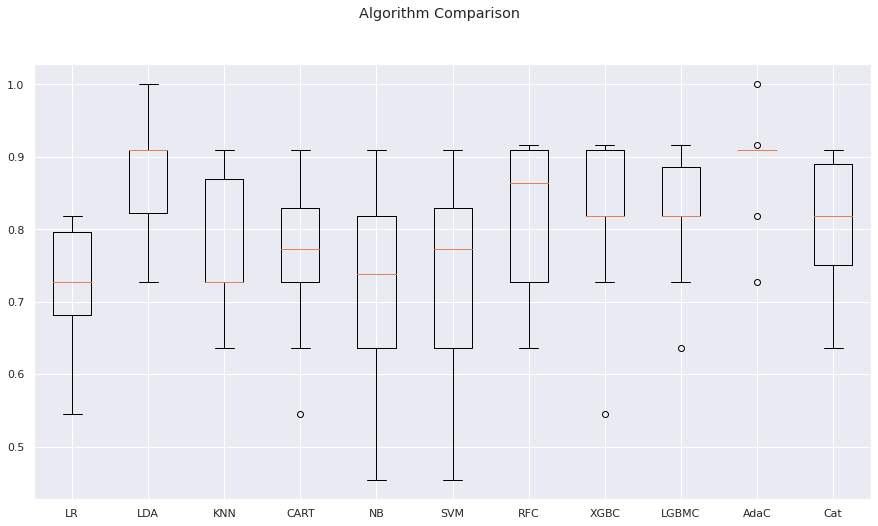

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
sex_model = AdaBoostClassifier()
sex_model.fit(train[sex_features].iloc[train['Sex'].dropna().index],train['Sex'].iloc[train['Sex'].dropna().index])
train['Sex'].iloc[np.where(train['Sex'].isnull()==True)] =  sex_model.predict(train[train['Sex'].isnull()][sex_features])
test['Sex'].iloc[np.where(test['Sex'].isnull()==True)] =  sex_model.predict(test[test['Sex'].isnull()][sex_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Delta 15 N 결측치 채우기

In [ ]:
Delta_features = ['Culmen Length (mm)', 'Culmen Depth (mm)',
       'Flipper Length (mm)','Species_Adelie Penguin (Pygoscelis adeliae)',
       'Species_Chinstrap penguin (Pygoscelis antarctica)',
       'Species_Gentoo penguin (Pygoscelis papua)', 'Island_Biscoe', 'Island_Dream', 'Island_Torgersen','Sex'
       ]

In [ ]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.116568 (0.036340) 
LASSO : -0.238135 (0.090412) 
KNN : -0.159055 (0.078713) 
CART : -0.239917 (0.123959) 
EN : -0.211953 (0.079840) 
SVM : -0.232461 (0.090579) 
RFR : -0.149528 (0.079932) 
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:10:10] WARNING: /workspace/src/object

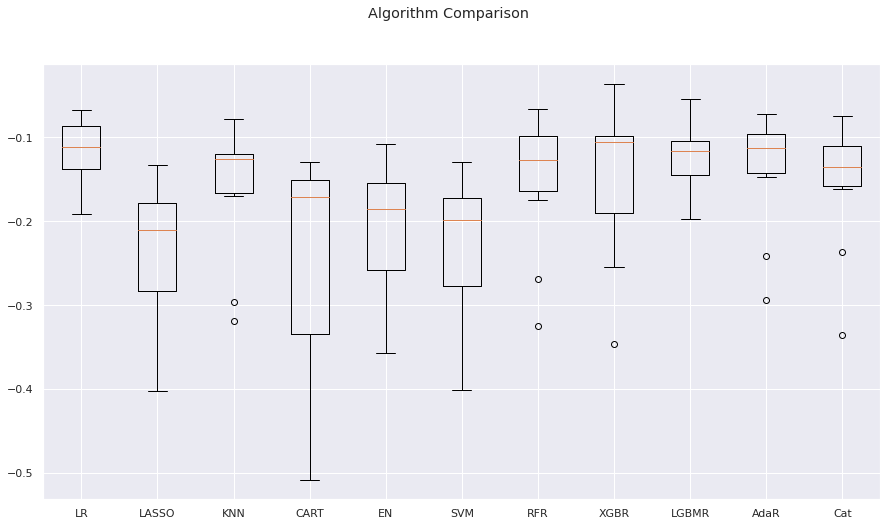

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
d15_model = AdaBoostRegressor()
d15_model.fit(train[Delta_features].iloc[train['Delta 15 N (o/oo)'].dropna().index]
                               ,train['Delta 15 N (o/oo)'].iloc[train['Delta 15 N (o/oo)'].dropna().index])
train['Delta 15 N (o/oo)'].iloc[np.where(train['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(train[train['Delta 15 N (o/oo)'].isnull()][Delta_features])
test['Delta 15 N (o/oo)'].iloc[np.where(test['Delta 15 N (o/oo)'].isnull()==True)] =  d15_model.predict(test[test['Delta 15 N (o/oo)'].isnull()][Delta_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Delta 13 C 결측치 채우기

In [ ]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor(iterations=10000,verbose=False)))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(iterations=10000,verbose=False)))
results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,cv= kfold,scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -0.282013 (0.152863) 
LASSO : -0.478706 (0.192187) 
KNN : -0.415174 (0.254843) 
CART : -0.518851 (0.273158) 
EN : -0.396727 (0.177711) 
SVM : -0.634220 (0.269142) 
RFR : -0.350851 (0.168368) 
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:12:04] WARNING: /workspace/src/object

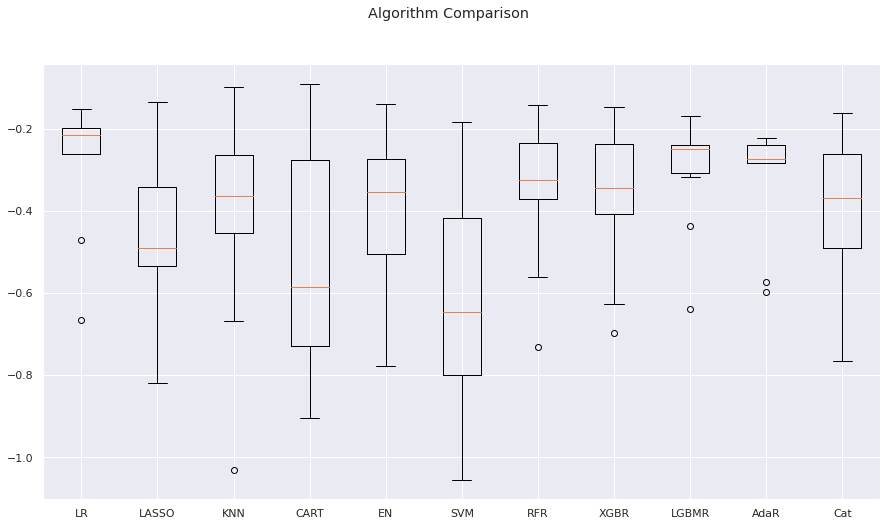

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
d13_model = LinearRegression()
d13_model.fit(train[Delta_features].iloc[train['Delta 13 C (o/oo)'].dropna().index]
                               ,train['Delta 13 C (o/oo)'].iloc[train['Delta 13 C (o/oo)'].dropna().index])
train['Delta 13 C (o/oo)'].iloc[np.where(train['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(train[train['Delta 13 C (o/oo)'].isnull()][Delta_features])
test['Delta 13 C (o/oo)'].iloc[np.where(test['Delta 13 C (o/oo)'].isnull()==True)] =  d13_model.predict(test[test['Delta 13 C (o/oo)'].isnull()][Delta_features])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
for col in test.columns:
    n_nan = test[col].isnull().sum()
    if n_nan>0:
      msg = '{:^20}에서 결측치 개수 : {}개'.format(col,n_nan)
      print(msg)

In [ ]:
num_folds= 10
seed = 7
scoring = 'neg_root_mean_squared_error'

In [ ]:
x = train[test.columns.tolist()]
y =train['Body Mass (g)']

In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(test))
# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for n, (train_idx, validation_idx) in enumerate(sfk.split(x, y)):      
    x_train, x_validation = train.iloc[train_idx], train.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
    model = Lasso(alpha=0.1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    mse = mean_squared_error(y_validation, y_pred, squared = False)
    print("{}번째 rmse는 {}".format(n, mse))

0번째 rmse는 9.440358169983904e-05
1번째 rmse는 0.00016856602186725197
2번째 rmse는 0.00015862709888422367
3번째 rmse는 0.00012359281413376413
4번째 rmse는 0.00010854350637511879


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


In [ ]:
from sklearn.model_selection import StratifiedKFold

n_splits = 5
sfk = StratifiedKFold(n_splits = n_splits)

y_pred = np.zeros(len(test))
# train데이터셋에서 건물의 비율을 동일하게하기 위해 StratifiedKFold 사용
for n, (train_idx, validation_idx) in enumerate(sfk.split(x, y)):      
    x_train, x_validation = train.iloc[train_idx], train.iloc[validation_idx]
    y_train, y_validation = y.iloc[train_idx], y.iloc[validation_idx]
    model = Ridge(alpha=0.1)
    model.fit(x_train, y_train)
    y_pred = model.predict(x_validation)
    mse = mean_squared_error(y_validation, y_pred, squared = False)
    print("{}번째 rmse는 {}".format(n, mse))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


0번째 rmse는 3.960702253822668e-06
1번째 rmse는 5.603593040270741e-06
2번째 rmse는 5.211874712867823e-06
3번째 rmse는 4.569470457668273e-06
4번째 rmse는 4.941484696050466e-06


In [ ]:
Ridge_model = model.fit(x, y)
predictions = Ridge_model.predict(test)

In [ ]:
submission = pd.read_csv("sample_submission.csv")

In [ ]:
submission

,id,Body Mass (g)
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
223,223,0
224,224,0
225,225,0
226,226,0


In [ ]:
submission["Body Mass (g)"] = predictions 

In [ ]:
submission

,id,Body Mass (g)
0,0,4342.73
1,1,5650.77
2,2,3603.11
3,3,3305.95
4,4,3520.55
...,...,...
223,223,4108.90
224,224,4737.16
225,225,4752.48
226,226,4090.71


In [ ]:
submission.to_csv('baseline.csv', index = False)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train[test.columns.tolist()],train['Body Mass (g)']
                                                      ,test_size=0.2,random_state=seed)

In [ ]:
models = []
models.append(('LR',LinearRegression()))
models.append(('LASSO',Lasso()))
models.append(('KNN',KNeighborsRegressor()))
models.append(('CART',DecisionTreeRegressor()))
models.append(('EN',ElasticNet()))
models.append(('SVM',SVR()))
models.append(('RFR',RandomForestRegressor()))
models.append(('XGBR',XGBRegressor()))
models.append(('LGBMR',LGBMRegressor()))
models.append(('AdaR',AdaBoostRegressor()))
models.append(('Cat',CatBoostRegressor(verbose=False)))
models.append(('Xtree',ExtraTreesRegressor()))

results =[]
names = []
for name, model in models:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

LR : -330.617595 (56.888526) 
LASSO : -329.243212 (55.682610) 
KNN : -388.766440 (54.708975) 
CART : -409.604242 (74.199833) 
EN : -376.023327 (58.073462) 
SVM : -775.629941 (193.158682) 
RFR : -333.489714 (80.706865) 
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:03] WARNING:

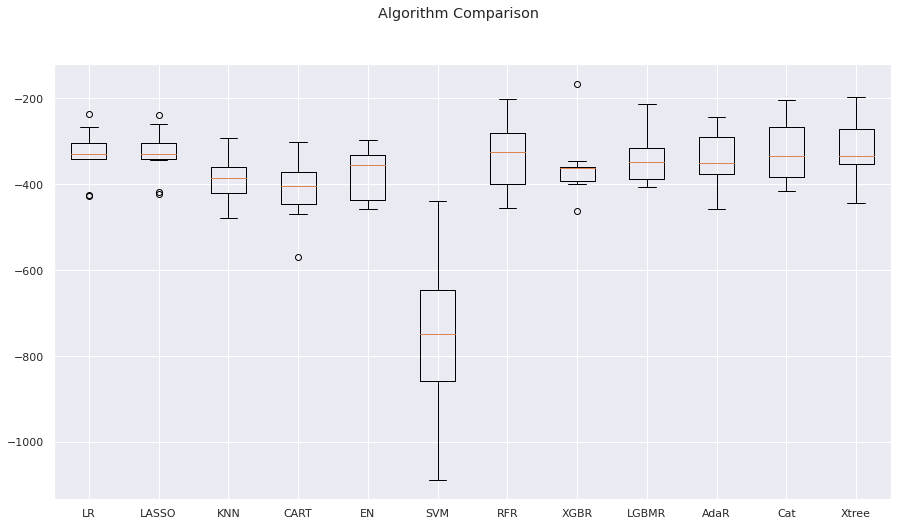

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [ ]:
pipelines = []
pipelines.append(('ScaledLR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO',Pipeline([('Scaler',preprocessing.StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledKNN',Pipeline([('Scaler',preprocessing.StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART',Pipeline([('Scaler',preprocessing.StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledEN',Pipeline([('Scaler',preprocessing.StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledSVM',Pipeline([('Scaler',preprocessing.StandardScaler()),('SVM',SVR())])))
pipelines.append(('ScaledRFR',Pipeline([('Scaler',preprocessing.StandardScaler()),('RFR',RandomForestRegressor())])))
pipelines.append(('ScaledXGBR',Pipeline([('Scaler',preprocessing.StandardScaler()),('XGBR',XGBRegressor())])))
pipelines.append(('ScaledLGBMR',Pipeline([('Scaler',preprocessing.StandardScaler()),('LGBMR',LGBMRegressor())])))
pipelines.append(('ScaledAdaR',Pipeline([('Scaler',preprocessing.StandardScaler()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('ScaledCat',Pipeline([('Scaler',preprocessing.StandardScaler()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('ScaledXtree',Pipeline([('Scaler',preprocessing.StandardScaler()),('Xtree',ExtraTreesRegressor())])))

results_scaled =[]
names_scaled = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_scaled.append(cv_results)
  names_scaled.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

ScaledLR : -330.617595 (56.888526) 
ScaledLASSO : -330.330902 (55.693388) 
ScaledKNN : -344.411139 (69.674407) 
ScaledCART : -423.022454 (74.348487) 
ScaledEN : -343.472443 (61.529554) 
ScaledSVM : -767.470621 (192.284946) 
ScaledRFR : -344.866564 (74.249856) 
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favo

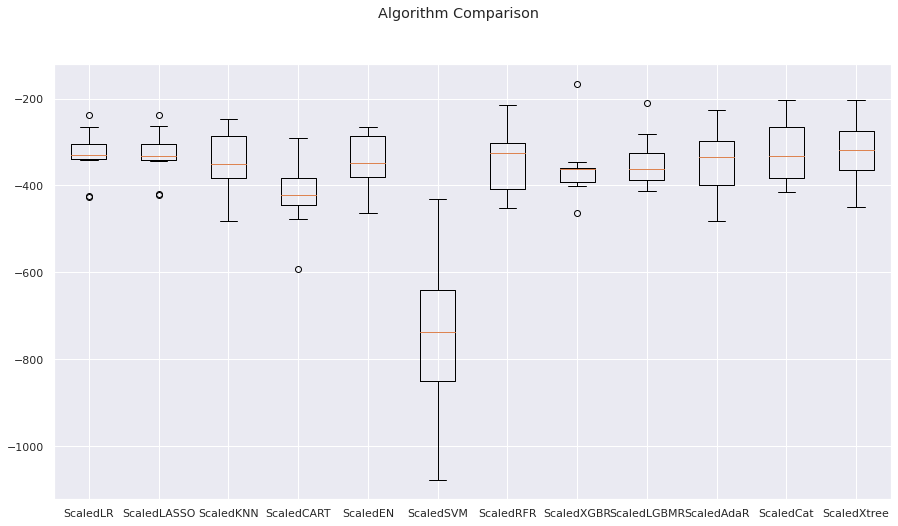

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_scaled)
ax.set_xticklabels(names_scaled)
plt.show()

In [ ]:
pipelines = []
pipelines.append(('NormLR',Pipeline([('Scaler',preprocessing.Normalizer()),('LR',LinearRegression())])))
pipelines.append(('NormLASSO',Pipeline([('Scaler',preprocessing.Normalizer()),('LASSO',Lasso())])))
pipelines.append(('NormKNN',Pipeline([('Scaler',preprocessing.Normalizer()),('KNN',KNeighborsRegressor())])))
pipelines.append(('NormCART',Pipeline([('Scaler',preprocessing.Normalizer()),('CART',DecisionTreeRegressor())])))
pipelines.append(('NormEN',Pipeline([('Scaler',preprocessing.Normalizer()),('EN',ElasticNet())])))
pipelines.append(('NormSVM',Pipeline([('Scaler',preprocessing.Normalizer()),('SVM',SVR())])))
pipelines.append(('NormRFR',Pipeline([('Scaler',preprocessing.Normalizer()),('RFR',RandomForestRegressor())])))
pipelines.append(('NormXGBR',Pipeline([('Scaler',preprocessing.Normalizer()),('XGBR',XGBRegressor())])))
pipelines.append(('NormLGBMR',Pipeline([('Scaler',preprocessing.Normalizer()),('LGBMR',LGBMRegressor())])))
pipelines.append(('NormAdaR',Pipeline([('Scaler',preprocessing.Normalizer()),('AdaR',AdaBoostRegressor())])))
pipelines.append(('NormCat',Pipeline([('Scaler',preprocessing.Normalizer()),('Cat',CatBoostRegressor(verbose=False))])))
pipelines.append(('NormXtree',Pipeline([('Scaler',preprocessing.Normalizer()),('Xtree',ExtraTreesRegressor())])))

results_norm =[]
names_norm = []
for name, model in pipelines:
  kfold = KFold(n_splits=10,random_state=7,shuffle = True)
  cv_results = cross_val_score(model,X_train,y_train
                               ,cv= kfold,scoring=scoring)
  results_norm.append(cv_results)
  names_norm.append(name)
  msg = "%s : %f (%f) "%(name,cv_results.mean(),cv_results.std())
  print(msg)

NormLR : -335.964391 (53.033894) 
NormLASSO : -535.592621 (76.550916) 
NormKNN : -384.185588 (43.164935) 
NormCART : -417.267178 (95.829229) 
NormEN : -771.844102 (171.084730) 
NormSVM : -776.125074 (193.274443) 
NormRFR : -340.149028 (87.987489) 
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[05:37:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squa

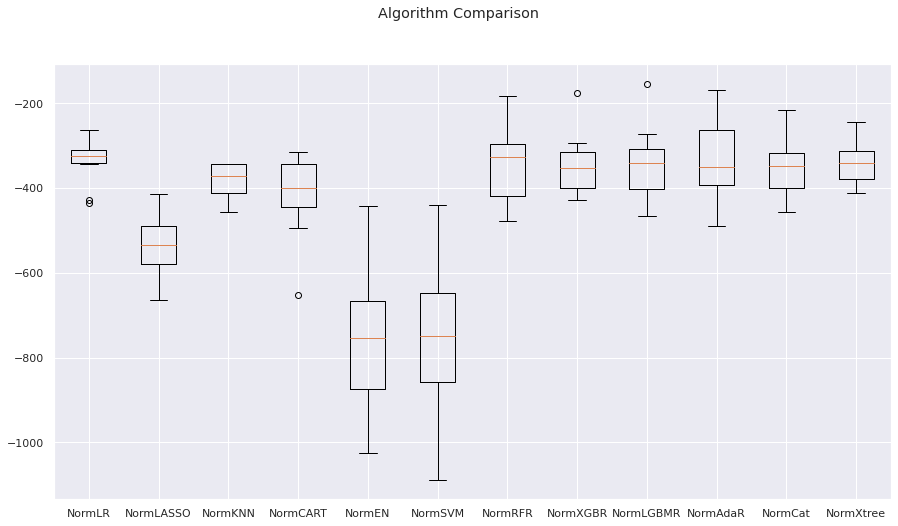

In [ ]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results_norm)
ax.set_xticklabels(names_norm)
plt.show()

In [ ]:
compare_algo_mean = pd.DataFrame([ i.mean() for i in results],columns=['Base'],index=names)
compare_algo_mean['Stand'] = [ i.mean() for i in results_scaled]
compare_algo_mean['Norm'] = [ i.mean() for i in results_norm]

<Figure size 1152x576 with 0 Axes>

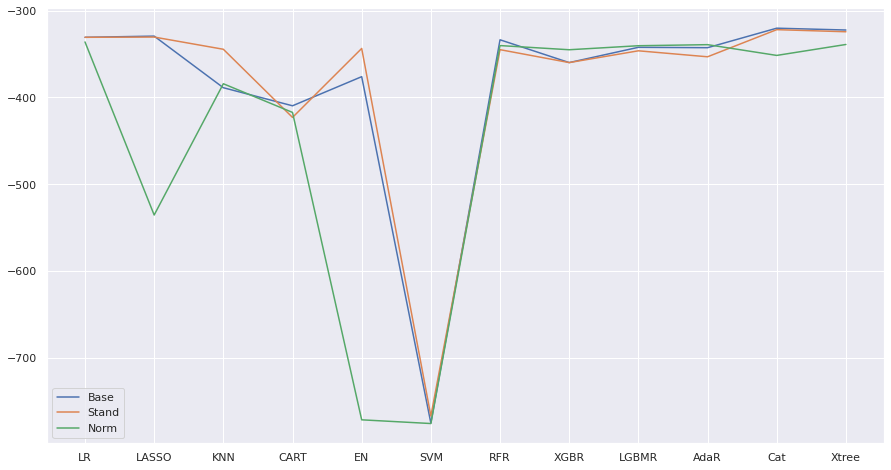

In [ ]:
plt.figure(figsize=(16,8))
ax =compare_algo_mean.plot()
plt.xticks(range(len(compare_algo_mean.index)), compare_algo_mean.index)
plt.show()

In [ ]:
compare_algo_mid = pd.DataFrame([ np.median(i) for i in results],columns=['Base'],index=names)
compare_algo_mid['Stand'] = [ np.median(i)for i in results_scaled]
compare_algo_mid['Norm'] = [ np.median(i) for i in results_norm]

<Figure size 1152x576 with 0 Axes>

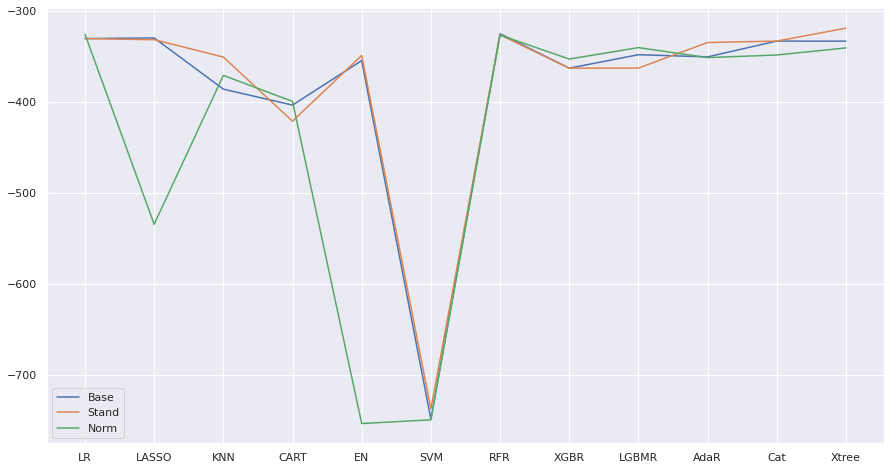

In [ ]:
plt.figure(figsize=(16,8))
ax =compare_algo_mid.plot()
plt.xticks(range(len(compare_algo_mid.index)), compare_algo_mid.index)
plt.show()

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_all)
scaled_X = scaler.transform(X_all)
params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6, 12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2, 8, 16, 20]
            }
model = RandomForestRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(scaled_X,y_all)

In [ ]:
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best : -327.891537 using {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 20, 'n_estimators': 50} 


In [ ]:
params = { 'n_estimators' : [10, 50,100],
           'max_depth' : [6,12,18,24],
           'min_samples_leaf' : [1, 6, 12, 18],
           'min_samples_split' : [2,4,8, 16]
            }
model =ExtraTreesRegressor()
kfold = KFold(n_splits= num_folds,random_state = seed,shuffle = True)
grid = GridSearchCV(estimator= model, param_grid = params,scoring= 'neg_root_mean_squared_error',cv=kfold )
grid_result = grid.fit(X_all,y_all)

In [ ]:
print("Best : %f using %s "%(grid_result.best_score_,grid_result.best_params_))

Best : -311.260586 using {'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 10} 


# 앙상블

In [ ]:
from sklearn.metrics import mean_squared_error
import math 

In [ ]:
errors = []
pred_valid=[]
pred_test = []

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(test)

Lasso

In [ ]:
lasso = Lasso()
lasso.fit(X_train,y_train)
lasso_valid = lasso.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lasso_valid))
errors.append(('Lasso',rmse))
pred_valid.append(('Lasso',lasso_valid))
lasso_test = lasso.predict(test)
pred_test.append(('Lasso',lasso_test))

Scaled LR

In [ ]:
LR =LinearRegression()
LR.fit(scaled_X_train,y_train)
lr_valid = LR.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, lr_valid))
errors.append(('LR',rmse))
pred_valid.append(('LR',lr_valid))
lr_test = LR.predict(scaled_X_test)
pred_test.append(('LR',lr_test))

Scaled RF

In [ ]:
RF =RandomForestRegressor(max_depth= 24, min_samples_leaf= 12, min_samples_split= 16, n_estimators= 10)
RF.fit(scaled_X_train,y_train)
rf_valid = RF.predict(scaled_X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, rf_valid))
errors.append(('RF',rmse))
pred_valid.append(('RF',rf_valid))
rf_test = RF.predict(scaled_X_test)
pred_test.append(('RF',rf_test))

Extra Tree

In [ ]:
ET = ExtraTreesRegressor(max_depth=24, min_samples_leaf= 1, min_samples_split= 8, n_estimators= 10)
ET.fit(X_train,y_train)
et_valid = ET.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, et_valid))
errors.append(('ET',rmse))
pred_valid.append(('ET',et_valid))
et_test = ET.predict(test)
pred_test.append(('ET',et_test))

CatBoost

In [ ]:
CAT = CatBoostRegressor(iterations=10000,random_state=7 
           ,eval_metric="RMSE")
CAT.fit(X_train,y_train, eval_set=[(X_valid,y_valid)],early_stopping_rounds=300
        ,verbose=1000 )
cat_valid = CAT.predict(X_valid)
rmse = math.sqrt(mean_squared_error(y_valid, cat_valid))
errors.append(('CAT',rmse))
pred_valid.append(('CAT',cat_valid))
cat_test = CAT.predict(test)
pred_test.append(('CAT',cat_test))

Learning rate set to 0.00858
0:	learn: 773.3176968	test: 779.5652857	best: 779.5652857 (0)	total: 1.45ms	remaining: 14.5s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 321.2889646
bestIteration = 565

Shrink model to first 566 iterations.


In [ ]:
for name, error in errors:
  print("{} : {}".format(name, error))


Lasso : 289.50474363460586
LR : 293.72789413836983
RF : 316.76667246382243
ET : 310.7882157481836
CAT : 321.2889646178319


In [ ]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  val+= (0.2* pred)
math.sqrt(mean_squared_error(y_valid, val))

286.5882886506189

In [ ]:
val= np.zeros(X_valid.shape[0])
for name, pred in pred_valid:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name=='CAT':
    val+= (0.25* pred)
math.sqrt(mean_squared_error(y_valid, val))

284.872295802673

In [ ]:
test_val= np.zeros(test.shape[0])
for name, pred in pred_test:
  if name == 'Lasso' or name=='LR' or name == 'ET' or name=='CAT':
    test_val+= (0.25* pred)

In [ ]:
submission = pd.read_csv('sample_submission.csv')
submission['Body Mass (g)'] = test_val
submission.to_csv("baseline.csv", index=False)